In [26]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Lambda
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt

from tqdm import tqdm

In [67]:
#check for gpu
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
    
# print(device)

In [51]:
device = torch.device("cpu")

In [53]:
train_dataset = datasets.CIFAR10(
    root = "data",
    transform = Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]),
    train = True,
    download= True)

test_dataset = datasets.CIFAR10(
    root = "data",
    transform = Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]),
    train = False,
    download= True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
# x_train, y_train, x_test, y_test = eecs598.data.cifar10()

# print('Training set:', )
# print('  data shape:', x_train.shape)
# print('  labels shape: ', y_train.shape)
# print('Test set:')
# print('  data shape: ', x_test.shape)
# print('  labels shape', y_test.shape)

In [59]:
# # Custom Dataset Class
# class TensorDataset(Dataset):
#     def __init__(self, images, labels):
#         self.images = images.flatten(start_dim=1)
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.images)  # Returns the size of the dataset
    
#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]
#         return image, label
    

# # Create dataset
# train_dataset = TensorDataset(x_train,y_train)
# test_dataset = TensorDataset(x_test, y_test)


# Create DataLoader to iterate over the dataset
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)



In [60]:
class Model(nn.Module):
    def __init__(self, n_classes: int, img_shape):
        super().__init__()
        
        size = 1
        for i in img_shape:
            size *= i
            
        self.layer = nn.Linear(in_features = size, out_features = n_classes)
        self.smax = nn.Softmax(dim = 1)
                                     
    def forward(self, x):
        return self.smax(self.layer(x))



In [61]:
model = Model(n_classes = 10, img_shape = x_train[40].shape).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

model

Model(
  (layer): Linear(in_features=3072, out_features=10, bias=True)
  (smax): Softmax(dim=1)
)

In [63]:
torch.manual_seed(42)
epochs = 200

losses = []
test_losses = []

for epoch in tqdm(range(epochs)):

    train_loss = 0

    for batch, (x,y) in enumerate(train_dataloader):
        model.train()
        
        y_pred = model(x.to(device))

        loss = loss_fn(y_pred, y.to(device))

        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    losses.append((train_loss / len(train_dataloader)).detach().cpu().numpy())
    
    
    
    with torch.inference_mode():
        
        test_loss = 0
        
        for x_test, y_test in test_dataloader:

            test_pred = model(x_test.to(device))

            test_loss += loss_fn(test_pred, y_test.to(device))

        
        test_losses.append((test_loss / len(test_dataloader)).detach().cpu().numpy())





100%|█████████████████████████████████████████| 200/200 [19:18<00:00,  5.79s/it]


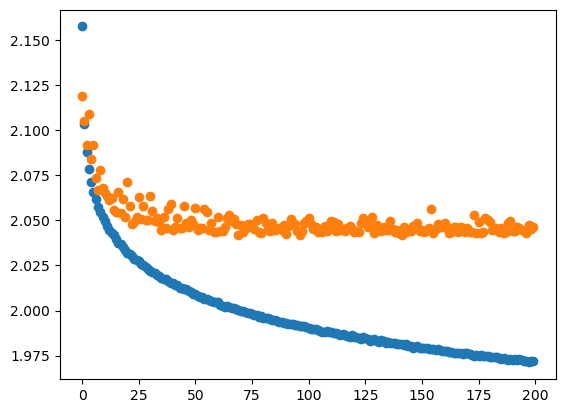

In [64]:
plt.scatter([i for i in range(len(losses))],losses)
plt.scatter([i for i in range(len(losses))],test_losses)

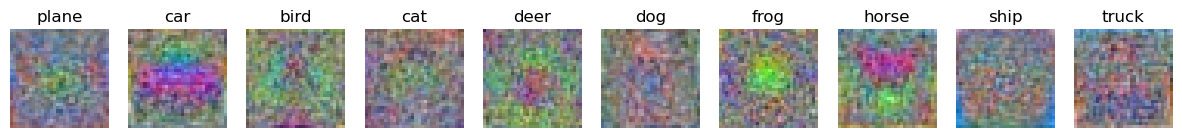

In [65]:
mx = model.layer.weight.max().item()
mn = model.layer.weight.min().item()

arr = (model.layer.weight - mn)/(mx-mn)

fig = plt.figure(figsize=(15,150))
j=1
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in arr:
    
    img = i.view(3,32,32).permute(1,2,0).detach().cpu().numpy()
    fig.add_subplot(1, 10, j)
    plt.imshow(img) 
    plt.title(classes[j-1]); 
    plt.axis(False);
    j+= 1
    


    